# Surface concentrations

In [2]:
import pickle
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import matplotlib.colors
from mpl_toolkits.basemap import Basemap, cm
import cmocean
import netCDF4 as nc
from itertools import compress
import datetime as dt
from datetime import date

%matplotlib notebook

###### Parameters:

In [9]:
imin, imax = 1480, 2180
jmin, jmax = 160, 800
isize = imax - imin
jsize = jmax - jmin

# model results:
# year  = 2015
# results_folder = '/data/brogalla/run_storage/riv-2b-202005/riv-2b-'+str(year)+'/'
year = 2002
results_folder1 = '/data/brogalla/run_storage/Mn-set5-202008/spin-up5/'
results_folder2 = '/data/brogalla/run_storage/Mn-set4-202004/ref-spin-up5/'
results_folder3 = '/data/brogalla/run_storage/spin-up0/'

In [4]:
stn_i = np.array([104-1, 100, 91, 175, 175, 233, 214, 352, 242, 458, 508, 547, 629])
stn_j = np.array([370, 365, 353, 311, 326, 313, 281, 281, 364, 332, 384, 457, 471])
stn_n = np.array(['CAA1','CAA2','CAA3','CAA4','CAA5','CAA6','CAA7',
                  'CAA8','CAA9', 'CB1','CB2','CB3','CB4'])

###### Load files:

In [5]:
mask      = nc.Dataset('/ocean/brogalla/GEOTRACES/ariane_runs/ANHA12_Ariane_mesh.nc')
tmask     = np.array(mask.variables['tmask'])[0,:,imin:imax,jmin:jmax]
land_mask = np.ma.masked_where((tmask[:,:,:] > 0.1), tmask[:,:,:]) 

In [6]:
ref   = nc.Dataset(results_folder2+'ANHA12_EXH006_'+str(year)+'_monthly.nc',  'r')
lons  = np.array(ref.variables['nav_lon'])
lats  = np.array(ref.variables['nav_lat'])
depth = np.array(ref.variables['deptht'])

In [20]:
results1  = nc.Dataset(results_folder1+'ANHA12_EXH006_'+str(year)+'_monthly.nc')
dissolmn1 = np.array(results1.variables['dissolmn'][:,0,:,:,:])*10**9 # nM units
oxidismn1 = np.array(results1.variables['oxidismn'][:,0,:,:,:])*10**9 # nM units

In [21]:
results2  = nc.Dataset(results_folder2+'ANHA12_EXH006_'+str(year)+'_monthly.nc')
dissolmn2 = np.array(results2.variables['dissolmn'][:,0,:,:,:])*10**9 # nM units
oxidismn2 = np.array(results2.variables['oxidismn'][:,0,:,:,:])*10**9 # nM units

In [16]:
mask      = nc.Dataset('/ocean/brogalla/GEOTRACES/ariane_runs/ANHA12_Ariane_mesh.nc')
tmask     = np.array(mask.variables['tmask'])[0,:,imin:imax,jmin:jmax]
land_mask = np.ma.masked_where((tmask[:,:,:] > 0.1), tmask[:,:,:]) 

e1t_base = np.array(mask.variables['e1t'])[0,imin:imax,jmin:jmax]
e2t_base = np.array(mask.variables['e2t'])[0,imin:imax,jmin:jmax]
e3t      = np.array(mask.variables['e3t_0'])[0,:,imin:imax,jmin:jmax]

e1t      = np.tile(e1t_base, (50,1,1))
e2t      = np.tile(e2t_base, (50,1,1))
volume   = e1t*e2t*e3t

##### Functions:

In [25]:
def plot_layer(month, layer, variable, vmin=0,vmax=35, savefig=False):
    
    fig, ax1, proj1 = pickle.load(open('/ocean/brogalla/GEOTRACES/pickles/mn-reference.pickle','rb'))

    x, y = proj1(lons, lats)

    contour = proj1.contourf(x, y, variable[month,layer,:,:], np.arange(vmin,vmax+1,0.25),\
                             cmap=cmocean.cm.dense, vmin=vmin, vmax=vmax, extend='both')

    cbar_ax = fig.add_axes([0.73, 0.16, 0.05, 0.6])
    cbar    = fig.colorbar(contour, cax=cbar_ax, ticks=[0,1,2,3,4,5,10,15,20,25,30])
    cbar.set_label('Dissolved Mn [nM]', fontsize=13) 
    cbar_ax.tick_params(axis='both', which='major', labelsize=13)
    
    if savefig:
        fig.savefig('/ocean/brogalla/GEOTRACES/figures/R3-surface-field-night'+\
                    str(date.today().strftime('%Y%m%d'))+'.png', bbox_inches='tight', dpi=300)
    
    return

In [18]:
def load_results(folder_ref):
    
    months  = ['01', '02', '03', '04', '05', '06', '07', '08', '09', '10', '11', '12']
    dmn_riv = np.empty((12,1,isize,jsize))   ; dmn_sed = np.empty((12,1,isize,jsize)); 
    dmn_atm = np.empty((12,1,isize,jsize))   ; dmn_ice = np.empty((12,1,isize,jsize));
    dmn_sedice = np.empty((12,1,isize,jsize));
    dmn_red = np.empty((12,50,isize,jsize)); dmn_oxi = np.empty((12,50,isize,jsize))
    
    i=0
    for month in months:
        file        = 'ANHA12_EXH006_1m_'+str(year)+'0101_'+str(year)+'1231_comp_'+str(year)+month+'-'+str(year)+month+'.nc'
        ref_monthly = nc.Dataset(folder_ref+file)
        
        dmn_riv[i,0,:,:]    = np.array(ref_monthly.variables['dmnriv'])[0,:,:]*(10**9)*(3600*24*31)
        dmn_sed[i,0,:,:]    = np.array(ref_monthly.variables['dmnsed'])[0,:,:]*(10**9)*(3600*24*31)
        dmn_sedice[i,0,:,:] = np.array(ref_monthly.variables['dmnsedice'])[0,:,:]*(10**9)*(3600*24*31)
        dmn_atm[i,0,:,:]    = np.array(ref_monthly.variables['dmnatm'])[0,:,:]*(10**9)*(3600*24*31)
        dmn_ice[i,0,:,:]    = np.array(ref_monthly.variables['dmnice'])[0,:,:]*(10**9)*(3600*24*31)
        dmn_red[i,:,:,:]  = np.array(ref_monthly.variables['dmnred'])[0,:,:,:]*(10**9)*(3600*24*31)
        dmn_oxi[i,:,:,:]  = np.array(ref_monthly.variables['dmnoxi'])[0,:,:,:]*(10**9)*(3600*24*31)
        i+=1
    
    tmask_surf    = np.empty(dmn_riv.shape)
    tmask_surf[:] = tmask[0,:,:]
    tmask_full    = np.empty(dmn_red.shape)
    tmask_full[:] = tmask
    
    # Mask points on land:
    dmn_mriv    = np.ma.masked_where((tmask_surf < 0.1), dmn_riv); 
    dmn_msed    = np.ma.masked_where((tmask_surf < 0.1), dmn_sed)
    dmn_msedice = np.ma.masked_where((tmask_surf < 0.1), dmn_sedice)
    dmn_matm    = np.ma.masked_where((tmask_surf < 0.1), dmn_atm)
    dmn_mice    = np.ma.masked_where((tmask_surf < 0.1), dmn_ice)
    dmn_mred    = np.ma.masked_where((tmask_full < 0.1), dmn_red)
    dmn_moxi    = np.ma.masked_where((tmask_full < 0.1), dmn_oxi)

    return dmn_mriv, dmn_msed, dmn_msedice, dmn_matm, dmn_mice, dmn_mred , dmn_moxi

##### Figures of surface concentrations:

<IPython.core.display.Javascript object>


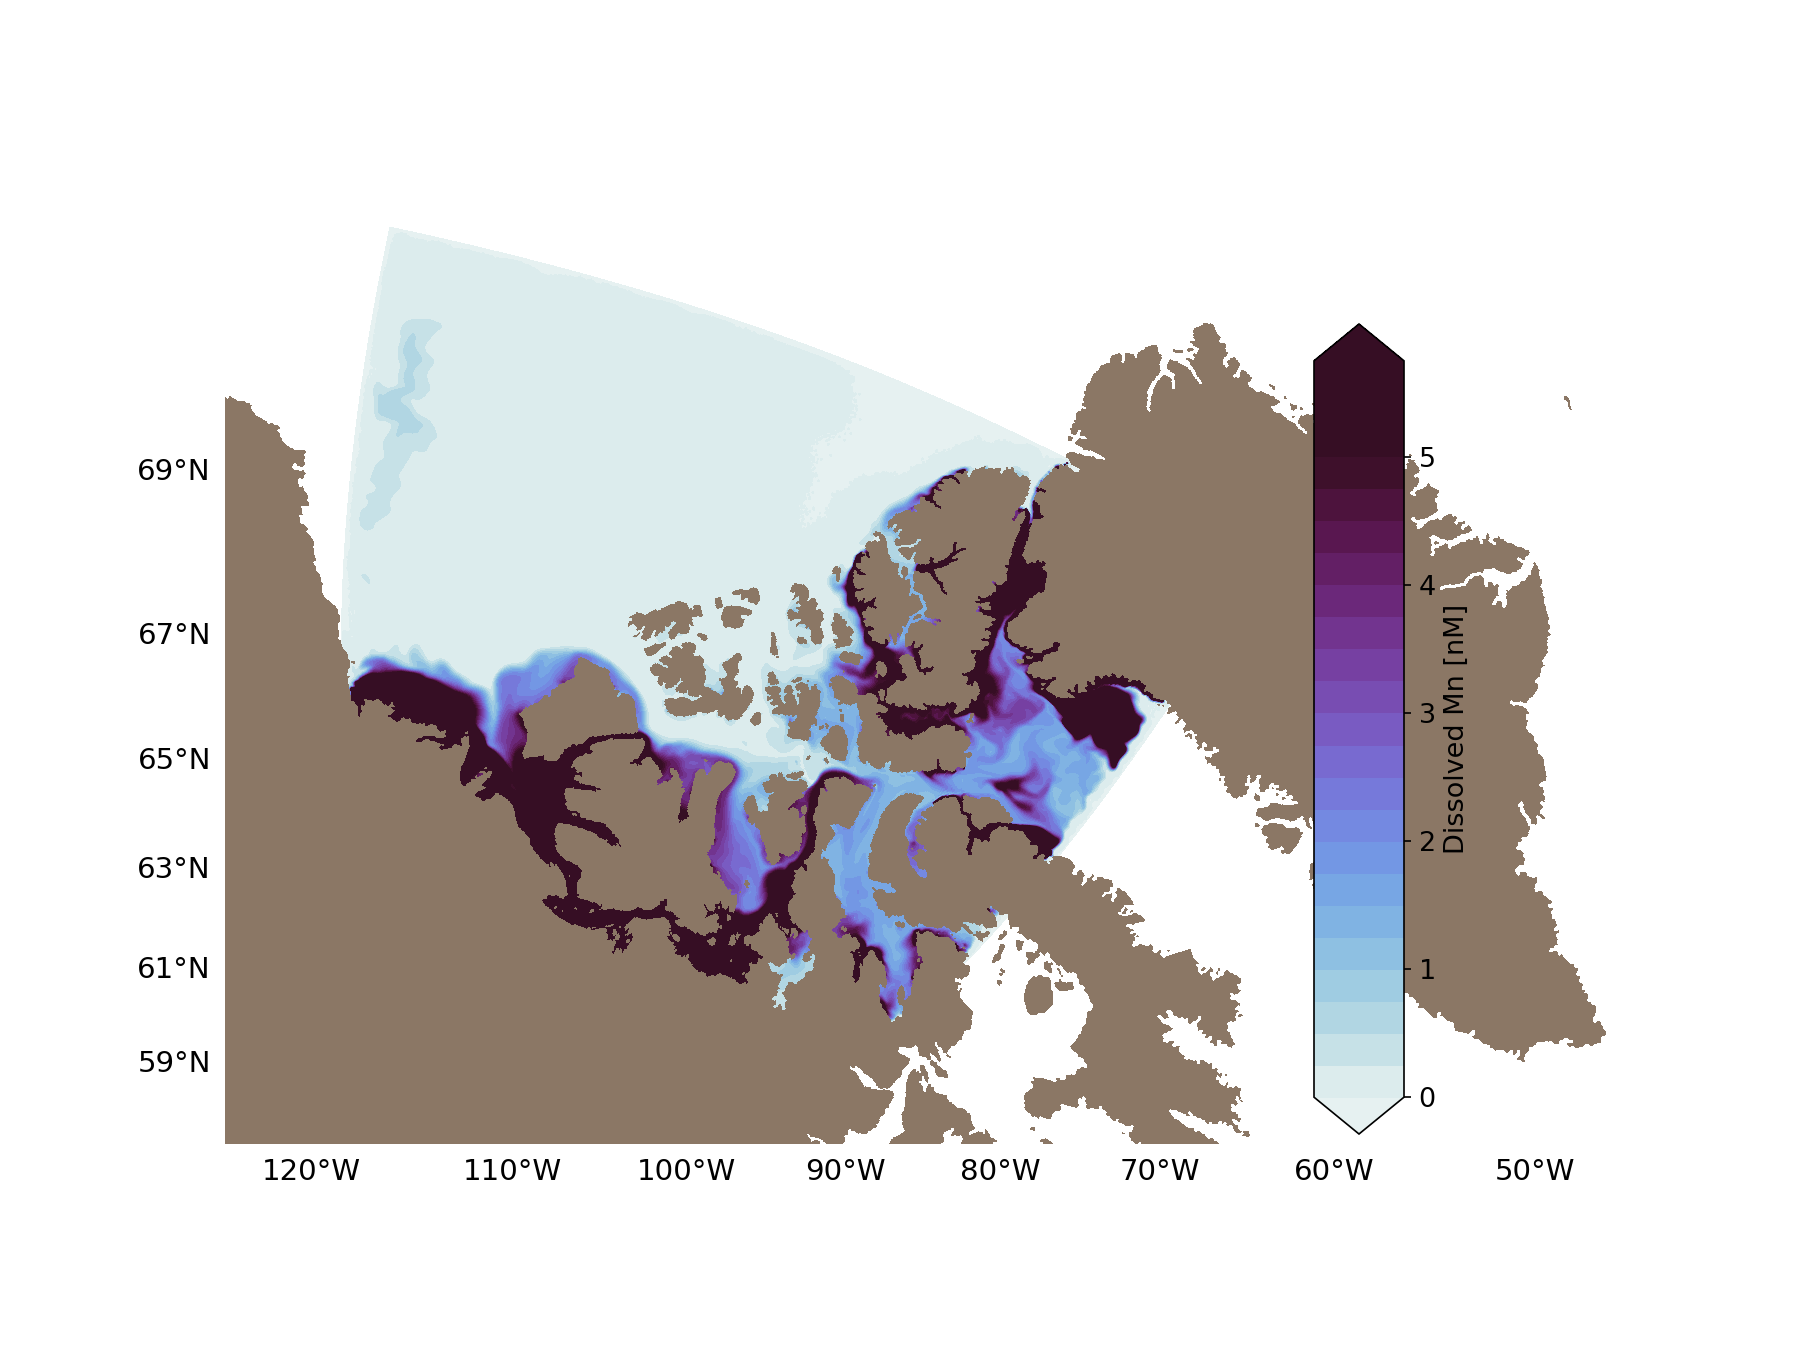

In [26]:
plot_layer(7,0,dissolmn1-dissolmn2,vmin=0,vmax=5)

<IPython.core.display.Javascript object>


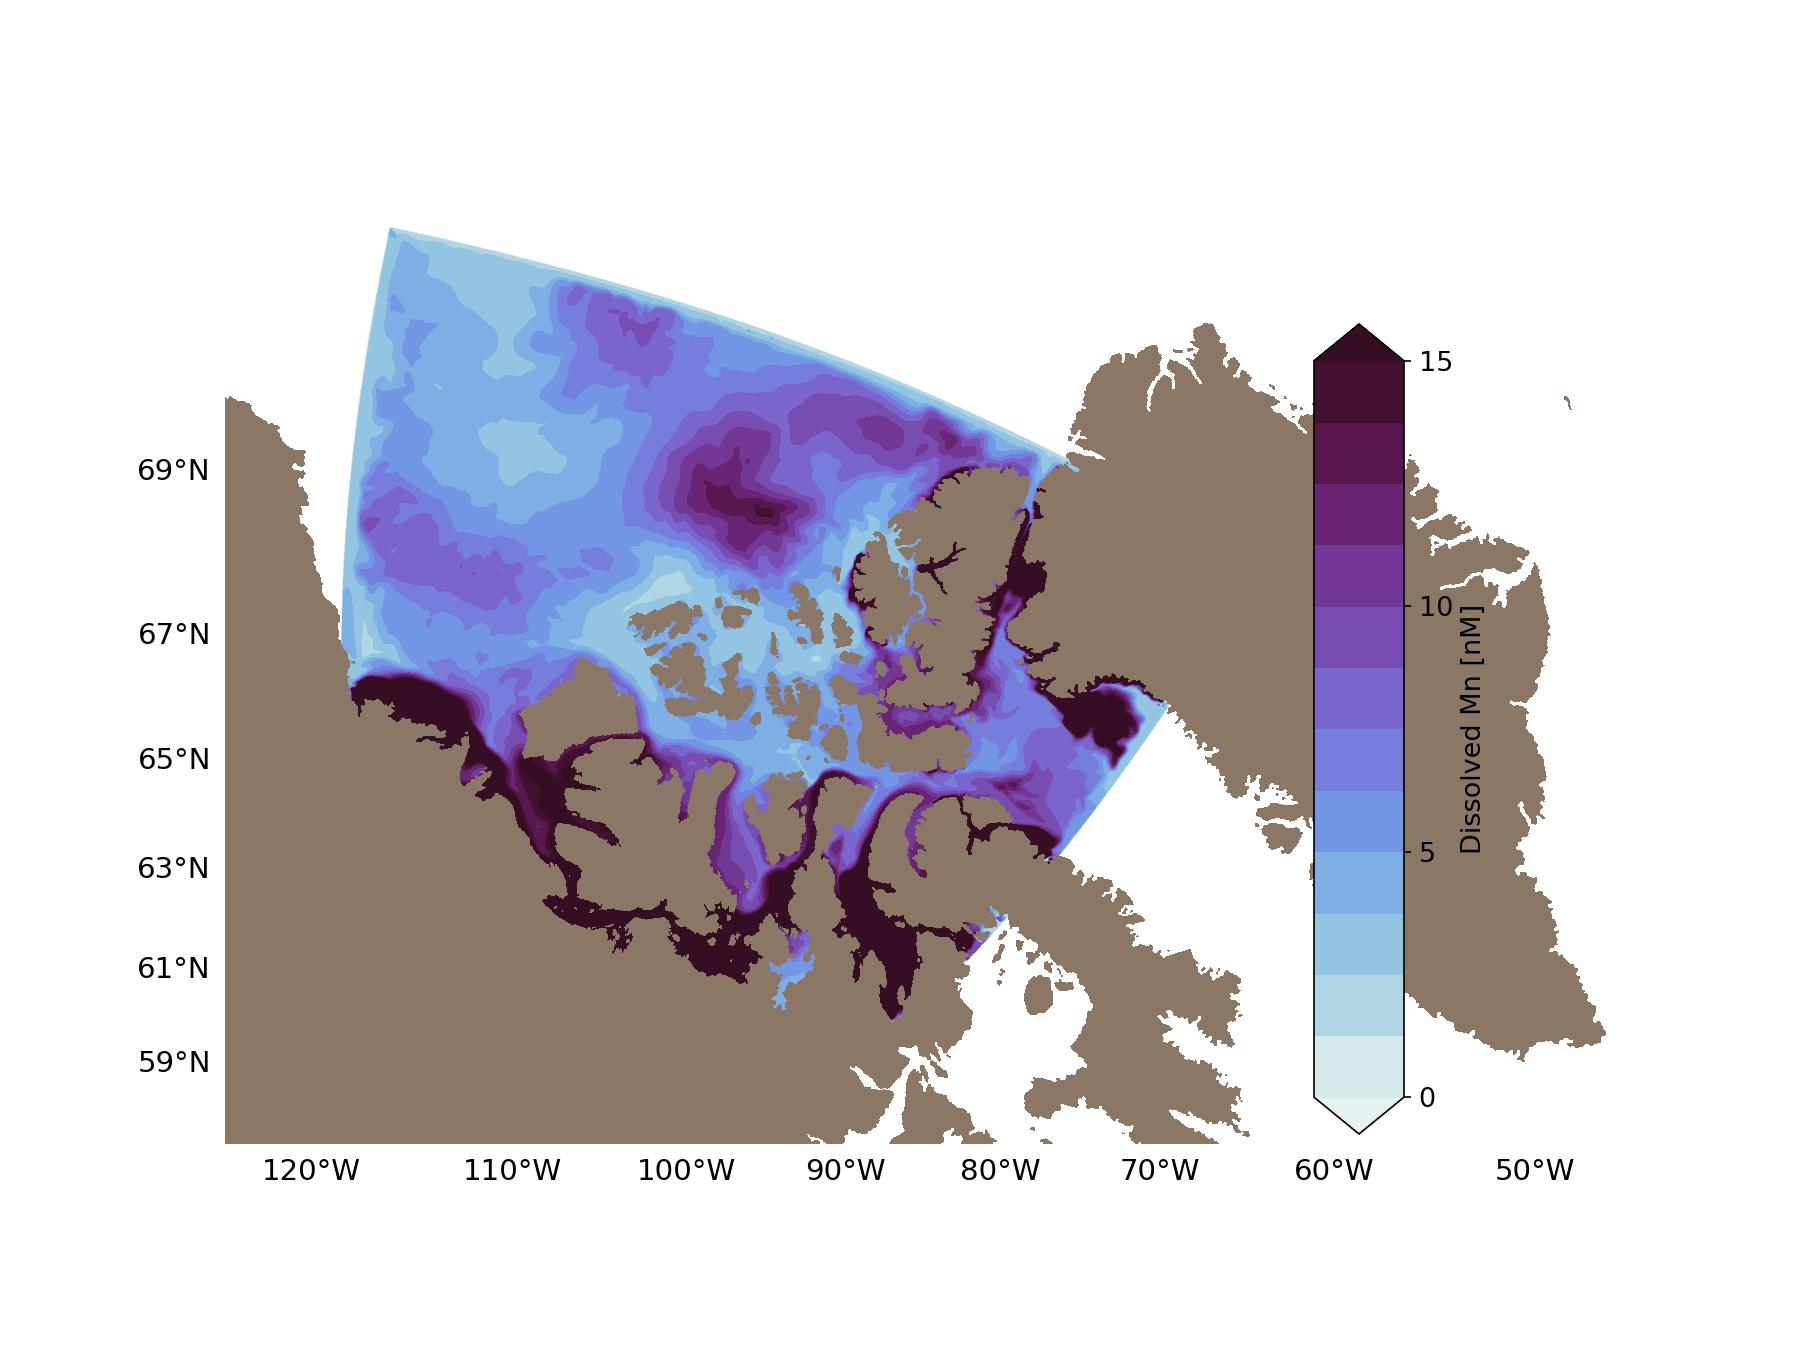

In [14]:
plot_layer(7,0,dissolmn,vmin=0,vmax=15)

<IPython.core.display.Javascript object>


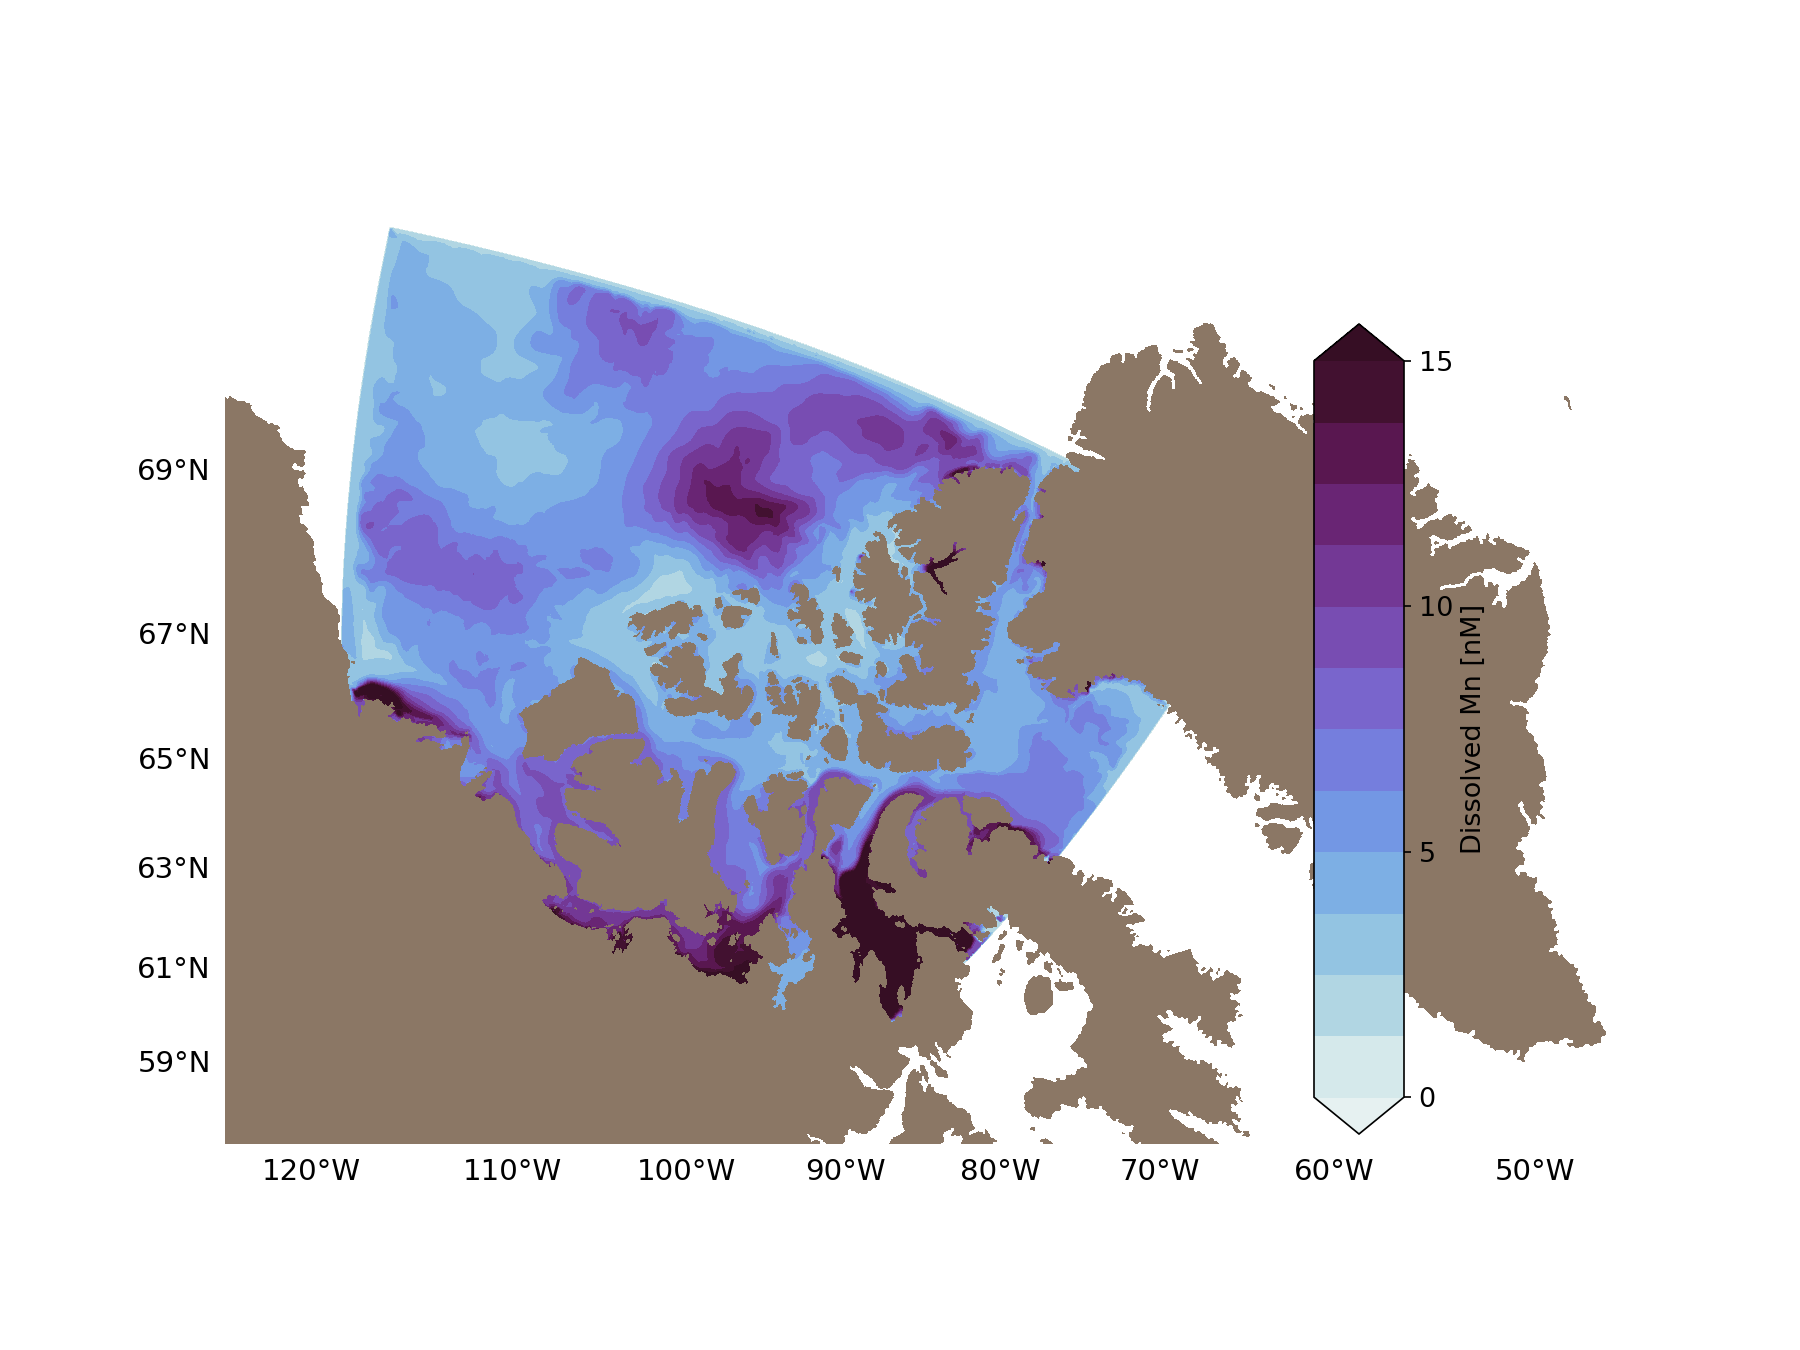

In [19]:
plot_layer(7,0,dissolmn,vmin=0,vmax=15)

## Surfaces around evaluation stations:

In [11]:
def eval_stns(month, layer, vmin=0, vmax=20):
    
    fig, ax1, proj1 = pickle.load(open('/ocean/brogalla/GEOTRACES/pickles/eastern-parry-channel.pickle','rb'))

    x, y = proj1(lons, lats)

    contour = proj1.contourf(x, y, dissolmn[month,layer,:,:], np.arange(vmin,vmax+1,.5),\
                                 cmap=cmocean.cm.dense, vmin=vmin, vmax=vmax, extend='both', zorder=2)

    proj1.contourf(x, y, np.ma.masked_where(land_mask[layer,:,:] > 0.1, land_mask[layer,:,:]), \
                   cmap=matplotlib.colors.ListedColormap(["#8b7765"]), zorder=3)

    x_stn, y_stn = proj1(lons[stn_i,stn_j], lats[stn_i,stn_j])
    proj1.plot(x_stn, y_stn, 'r*', markersize=14, markeredgecolor='w', zorder=4)

    cbar_ax = fig.add_axes([0.91, 0.19, 0.05, 0.6])
    cbar    = fig.colorbar(contour, cax=cbar_ax)
#     cbar.set_label('Dissolved Mn [nM]', fontsize=13) 
    cbar_ax.tick_params(axis='both', which='major', labelsize=13)
    
    return

<IPython.core.display.Javascript object>


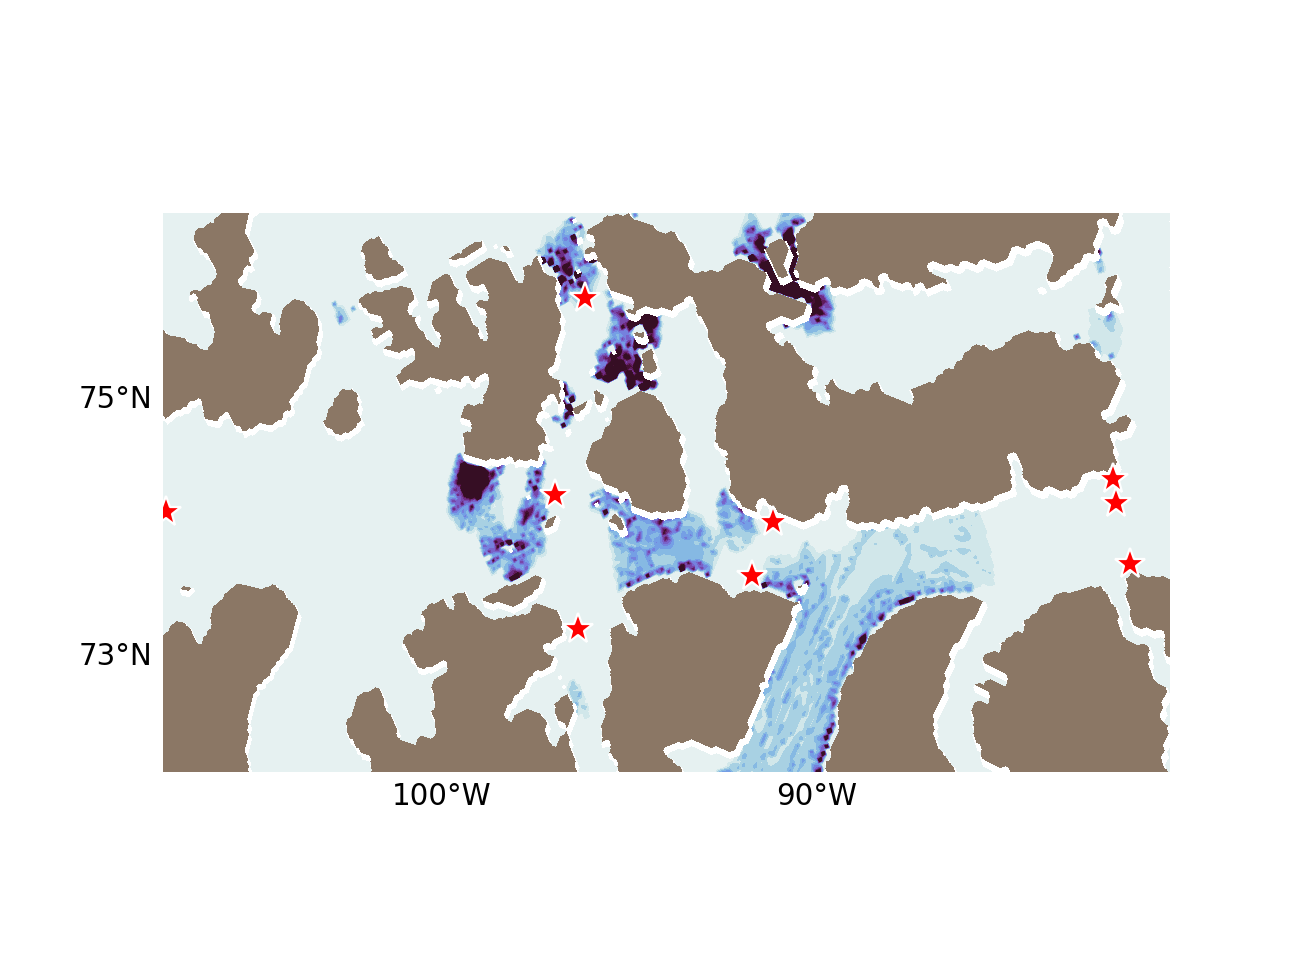

In [101]:
fig, ax1, proj1 = pickle.load(open('/ocean/brogalla/GEOTRACES/pickles/eastern-parry-channel.pickle','rb'))

x, y = proj1(lons, lats)

vmin = 0
vmax = 10

contour = proj1.contourf(x, y, dmn_sed[6,0,:,:], np.arange(vmin,vmax+1,),\
                                 cmap=cmocean.cm.dense, vmin=vmin, vmax=vmax, extend='both', zorder=2)

x_stn, y_stn = proj1(lons[stn_i,stn_j], lats[stn_i,stn_j])
proj1.plot(x_stn, y_stn, 'r*', markersize=14, markeredgecolor='w', zorder=4)

<IPython.core.display.Javascript object>


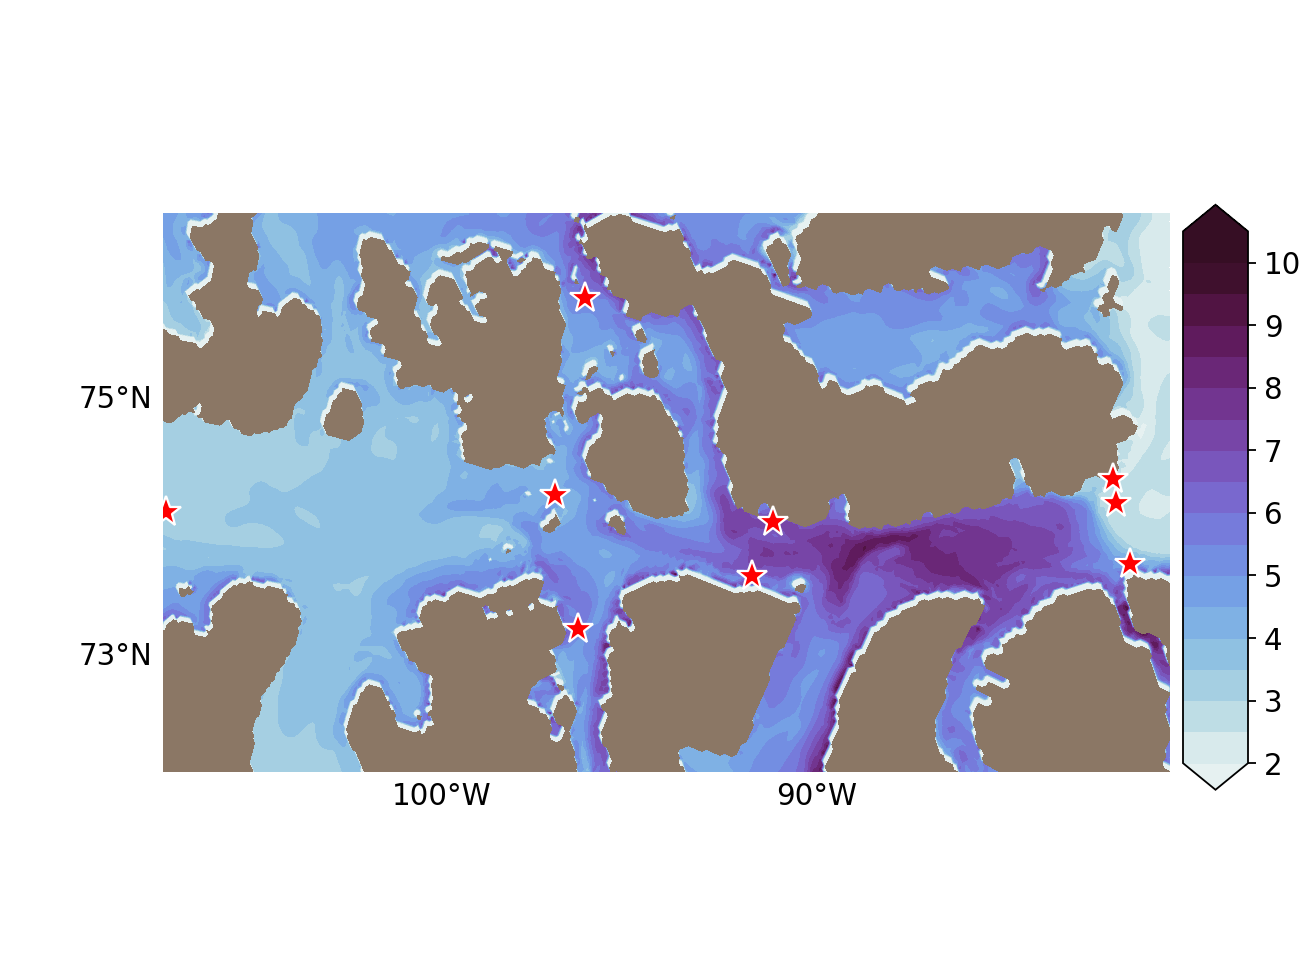

In [75]:
eval_stns(6, 10, vmin=2, vmax=10) # depth of 14 m